# Proyecto Redes Neuronales: Perceptrón Multicapa

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo de Perceptrón Multicapa (MLP) para clasificación de texto según el enunciado del proyecto.  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos
3. Tokenización y Creación del Vocabulario
4. Construcción del Modelo MLP
5. Entrenamiento con Early Stopping
6. Evaluación del Modelo
7. Guardado de Resultados y Modelos
8. Visualización de Resultados
9. Historial de Experimentos

## 0. Configuración de Parámetros Globales

Esta sección permite modificar fácilmente todos los parámetros del modelo para experimentar.

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====
# Esta sección centraliza todos los parámetros del modelo para facilitar experimentación

# Configuración general del experimento
EXPERIMENT_NAME = "MultiLayer_Perceptron"
MODEL_TYPE = "MLP"  # Perceptrón Multi-Capa  
RANDOM_SEED = 42

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = "models"
OUTPUT_DIR = "output"

# Configuración del dataset
TEXT_COLUMN = "review_body"  # Columna con el texto a clasificar
TARGET_COLUMN = "stars"  # Columna con las etiquetas (1-5 estrellas)
LANGUAGE_COLUMN = "language"  # Columna con el idioma
FILTER_LANGUAGE = "en"  # Filtrar por idioma específico. Opciones: None, "en", "es", "de", "fr", "ja"
MAX_WORDS = 80000  # Tamaño máximo del vocabulario
MAX_LENGTH = 250  # Longitud máxima de las secuencias
OOV_TOKEN = "<OOV>"  # Token para palabras fuera del vocabulario

# Parámetros de arquitectura del modelo - MLP
EMBEDDING_DIM = 300  # Dimensión del embedding de palabras
HIDDEN_LAYERS = [256, 128, 64]  # Lista con el número de neuronas en cada capa oculta
ACTIVATION = "relu"  # Función de activación para capas ocultas
OUTPUT_ACTIVATION = "softmax"  # Función de activación para la capa de salida
DROPOUT_RATE = 0.3  # Tasa de dropout para regularización

# Parámetros de entrenamiento
EPOCHS = 50  # Número máximo de épocas de entrenamiento
BATCH_SIZE = 512  # Tamaño del batch
LEARNING_RATE = 0.001  # Tasa de aprendizaje
PATIENCE = 10  # Paciencia para early stopping
OPTIMIZER = "adam"  # Optimizador a usar
LOSS_FUNCTION = "categorical_crossentropy"  # Función de pérdida
METRICS = ["accuracy"]  # Métricas a monitorear

print(f"=== Configuración del Experimento: {EXPERIMENT_NAME} ===")
print(f"Modelo: {MODEL_TYPE}")
print(f"Filtro de idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Arquitectura oculta: {HIDDEN_LAYERS}")
print(f"Dimensión embedding: {EMBEDDING_DIM}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Épocas máximas: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Tasa de aprendizaje: {LEARNING_RATE}")
print("="*60)

=== Configuración del Experimento: MultiLayer_Perceptron ===
Modelo: MLP
Filtro de idioma: en
Arquitectura oculta: [256, 128, 64]
Dimensión embedding: 300
Dropout: 0.3
Épocas máximas: 50
Batch size: 512
Tasa de aprendizaje: 0.001


## 1. Importación de Librerías y Funciones Helper

In [2]:
# Librerías estándar
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Librerías de machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Importar funciones helper
from helper import (
    DataLoader, ModelTrainer, ResultsManager, Visualizer,
    evaluate_model, get_gpu_info, setup_experiment_environment
)

# Configurar ambiente del experimento
gpu_info = setup_experiment_environment(RANDOM_SEED)
print(f"Ambiente configurado. GPU disponible: {gpu_info['gpu_available']}")

2025-09-28 16:57:34.702017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 16:57:34.740120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 16:57:35.658201: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU configurada: 1 GPU(s) disponibles
Ambiente configurado. GPU disponible: True


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Inicializar el cargador de datos
data_loader = DataLoader(data_dir=DATA_DIR)

# Cargar los datasets
print("Cargando datasets...")
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales cargados:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras") 
print(f"Prueba: {len(test_df)} muestras")

# Analizar distribución de idiomas
print(f"\nAnálisis de idiomas en el dataset:")
if LANGUAGE_COLUMN in train_df.columns:
    lang_dist_train = train_df[LANGUAGE_COLUMN].value_counts()
    print(f"Distribución de idiomas (entrenamiento):")
    for lang, count in lang_dist_train.items():
        percentage = (count / len(train_df)) * 100
        print(f"  {lang}: {count:,} muestras ({percentage:.1f}%)")
    
    # Aplicar filtro por idioma si está especificado
    if FILTER_LANGUAGE is not None:
        if FILTER_LANGUAGE in lang_dist_train.index:
            print(f"\n🔍 Filtrando por idioma: {FILTER_LANGUAGE}")
            
            # Filtrar datasets por idioma
            train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            
            print(f"\nDatos después del filtrado por idioma '{FILTER_LANGUAGE}':")
            print(f"Entrenamiento: {len(train_df)} muestras")
            print(f"Validación: {len(val_df)} muestras")
            print(f"Prueba: {len(test_df)} muestras")
        else:
            print(f"\n⚠️  Advertencia: Idioma '{FILTER_LANGUAGE}' no encontrado en el dataset.")
            print(f"Idiomas disponibles: {list(lang_dist_train.index)}")
            print("Usando todos los idiomas...")
    else:
        print(f"\n📊 Usando todos los idiomas disponibles")
else:
    print(f"⚠️  Columna '{LANGUAGE_COLUMN}' no encontrada. Usando todos los datos sin filtrar.")

# Mostrar distribución de clases en el conjunto final
print(f"\nDistribución de clases (conjunto final):")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} muestras ({percentage:.1f}%)")

# Mostrar ejemplos de datos
print(f"\nEjemplos de datos del conjunto final:")
for i in range(min(3, len(train_df))):
    lang = train_df[LANGUAGE_COLUMN].iloc[i] if LANGUAGE_COLUMN in train_df.columns else "N/A"
    text = train_df[TEXT_COLUMN].iloc[i][:100]
    stars = train_df[TARGET_COLUMN].iloc[i]
    print(f"{i+1}. [{lang}] {stars}⭐ - {text}...")

Cargando datasets...
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales cargados:
Entrenamiento: 1200000 muestras
Validación: 30000 muestras
Prueba: 30000 muestras

Análisis de idiomas en el dataset:
Distribución de idiomas (entrenamiento):
  de: 200,000 muestras (16.7%)
  en: 200,000 muestras (16.7%)
  es: 200,000 muestras (16.7%)
  fr: 200,000 muestras (16.7%)
  ja: 200,000 muestras (16.7%)
  zh: 200,000 muestras (16.7%)

🔍 Filtrando por idioma: en

Datos después del filtrado por idioma 'en':
Entrenamiento: 200000 muestras
Validación: 5000 muestras
Prueba: 5000 muestras

Distribución de clases (conjunto final):
  1 estrella(s): 40,000 muestras (20.0%)
  2 estrella(s): 40,000 muestras (20.0%)
  3 estrella(s): 40,000 muestras (20.0%)
  4 estrella(s): 40,000 muestras (20.0%)
  5 estrella(s): 40,000 muestras (20.0%)

Ejemplos de datos del conjunto final:
1. [en] 1⭐ - Arrived broken. Manufacturer defec

### 💡 Configuraciones Rápidas por Idioma

Para cambiar el idioma del experimento, modifica la variable `FILTER_LANGUAGE` en la primera celda:

```python
# Opciones disponibles:
FILTER_LANGUAGE = None     # Todos los idiomas (por defecto)
FILTER_LANGUAGE = "en"     # Solo inglés 
FILTER_LANGUAGE = "es"     # Solo español
FILTER_LANGUAGE = "de"     # Solo alemán
FILTER_LANGUAGE = "fr"     # Solo francés
FILTER_LANGUAGE = "ja"     # Solo japonés
```

**Recomendaciones:**
- **`"en"` (Inglés)**: Mayor cantidad de datos, vocabulario más rico
- **`"es"` (Español)**: Bueno para comparar rendimiento en español
- **`None` (Todos)**: Para experimentos multiidioma
- **Otros idiomas**: Para análisis específicos por idioma

In [4]:
# 🚀 CONFIGURACIÓN RÁPIDA - Descomenta una línea para cambiar idioma
# FILTER_LANGUAGE = None      # ✅ Por defecto: todos los idiomas
# FILTER_LANGUAGE = "en"      # 🇺🇸 Solo inglés (recomendado para mejor rendimiento)
# FILTER_LANGUAGE = "es"      # 🇪🇸 Solo español 
# FILTER_LANGUAGE = "de"      # 🇩🇪 Solo alemán
# FILTER_LANGUAGE = "fr"      # 🇫🇷 Solo francés
# FILTER_LANGUAGE = "ja"      # 🇯🇵 Solo japonés

# Si cambias el idioma aquí, ejecuta esta celda y vuelve a ejecutar desde la carga de datos
print(f"Configuración actual: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Todos los idiomas'}")
print("💡 Tip: Para inglés únicamente (mejor rendimiento), descomenta: FILTER_LANGUAGE = 'en'")

Configuración actual: en
💡 Tip: Para inglés únicamente (mejor rendimiento), descomenta: FILTER_LANGUAGE = 'en'


## 3. Preprocesamiento de Texto

In [5]:
# Preprocesar los datos de texto
print("Preprocesando datos de texto...")
processed_data = data_loader.preprocess_text_data(
    train_df=train_df,
    val_df=val_df, 
    test_df=test_df,
    text_column=TEXT_COLUMN,
    target_column=TARGET_COLUMN,
    max_words=MAX_WORDS,
    max_length=MAX_LENGTH
)

# Extraer datos preprocesados
X_train, y_train = processed_data['X_train'], processed_data['y_train']
X_val, y_val = processed_data['X_val'], processed_data['y_val']
X_test, y_test = processed_data['X_test'], processed_data['y_test']
num_classes = processed_data['num_classes']
vocab_size = processed_data['vocab_size']

print(f"\nDatos preprocesados:")
print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Número de clases: {num_classes}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

# Obtener nombres de clases para evaluación
class_names = [str(i) for i in data_loader.label_encoder.classes_]

Preprocesando datos de texto...
Preprocesando datos de texto...
Tamaño del vocabulario: 47436
Número de clases: 5
Longitud de secuencia: 250
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Datos preprocesados:
Tamaño del vocabulario: 47437
Número de clases: 5
Forma de X_train: (200000, 250)
Forma de y_train: (200000, 5)


## 4. Construcción del Modelo MLP

In [6]:
def create_mlp_model(vocab_size, embedding_dim, max_length, hidden_layers, 
                     num_classes, dropout_rate, activation, output_activation):
    """
    Crear un modelo de Perceptrón Multicapa para clasificación de texto.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión del embedding
        max_length: Longitud máxima de secuencia
        hidden_layers: Lista con el número de neuronas en cada capa oculta
        num_classes: Número de clases de salida
        dropout_rate: Tasa de dropout
        activation: Función de activación para capas ocultas
        output_activation: Función de activación para la capa de salida
    
    Returns:
        tf.keras.Model: Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding (sin input_length que está deprecado)
    model.add(Embedding(input_dim=vocab_size, 
                       output_dim=embedding_dim,
                       name="embedding_layer"))
    
    # Pooling global para reducir dimensionalidad
    model.add(GlobalAveragePooling1D(name="global_avg_pooling"))
    
    # Capas ocultas del MLP
    for i, units in enumerate(hidden_layers):
        model.add(Dense(units=units, 
                       activation=activation, 
                       name=f"dense_layer_{i+1}"))
        model.add(Dropout(rate=dropout_rate, 
                         name=f"dropout_{i+1}"))
    
    # Capa de salida
    model.add(Dense(units=num_classes, 
                   activation=output_activation, 
                   name="output_layer"))
    
    return model

# Crear el modelo
print("Creando modelo MLP...")
model = create_mlp_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_LENGTH,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    activation=ACTIVATION,
    output_activation=OUTPUT_ACTIVATION
)

# Compilar el modelo
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=LOSS_FUNCTION,
    metrics=METRICS
)

# Construir el modelo con la forma de entrada específica
model.build(input_shape=(None, MAX_LENGTH))

# Mostrar arquitectura del modelo
print("\nArquitectura del modelo:")
model.summary()

# Contar parámetros
total_params = model.count_params()
print(f"\nTotal de parámetros: {total_params:,}")

Creando modelo MLP...


I0000 00:00:1759096666.847287   68645 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9495 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 250, 300)       │    14,231,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,349,633 (54.74 MB)

 Trainable params: 14,349,633 (54.74 MB)

 Non-trainable params: 0 (0.00 B)


Total de parámetros: 14,349,633


## 5. Entrenamiento del Modelo

In [7]:
# Inicializar el entrenador de modelos
model_trainer = ModelTrainer(model_dir=MODEL_DIR)

# Entrenar el modelo
print("Iniciando entrenamiento...")
training_results = model_trainer.train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

print(f"\nEntrenamiento completado:")
print(f"Épocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo de entrenamiento: {training_results['training_time']:.1f} segundos")
print(f"Accuracy final (entrenamiento): {training_results['final_train_accuracy']:.4f}")
print(f"Accuracy final (validación): {training_results['final_val_accuracy']:.4f}")

Iniciando entrenamiento...
Entrenando MLP_20250928_165747...
Parámetros del modelo: 14,349,633
Epoch 1/50


2025-09-28 16:57:48.092797: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fa530006b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-28 16:57:48.092817: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-28 16:57:48.114259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-28 16:57:48.249764: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-28 16:57:48.366547: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 16:57:48.366615: I e

 10/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2086 - loss: 1.6103

I0000 00:00:1759096671.649461   68800 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2145 - loss: 1.6055

2025-09-28 16:57:58.663193: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 16:57:58.663268: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 16:57:59.341709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1524', 580 bytes spill stores, 580 bytes spill loads

2025-09-28 16:57:59.594849: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2146 - loss: 1.6054

2025-09-28 16:58:01.829641: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 16:58:02.430103: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_106', 116 bytes spill stores, 116 bytes spill loads

2025-09-28 16:58:02.984310: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 16:58:03.546580: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.2355 - loss: 1.5905 - val_accuracy: 0.3270 - val_loss: 1.5451 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3098 - loss: 1.4994 - val_accuracy: 0.3816 - val_loss: 1.3730 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3858 - loss: 1.3522 - val_accuracy: 0.4180 - val_loss: 1.3014 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4378 - loss: 1.2605 - val_accuracy: 0.4500 - val_loss: 1.2290 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4731 - loss: 1.1986 - val_accuracy: 0.4780 - val_loss: 1.1841 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4868 - loss: 1.1729 - val_accuracy: 0.4822 - val_loss: 1.1702 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4967 - loss: 1.1498 - val

Modelo guardado en: models/MLP_20250928_165747.h5

Entrenamiento completado:
Épocas entrenadas: 26
Tiempo de entrenamiento: 184.9 segundos
Accuracy final (entrenamiento): 0.5707
Accuracy final (validación): 0.5116


## 6. Visualización del Entrenamiento

Gráfico de historial de entrenamiento guardado en: output/MLP_training_history.png


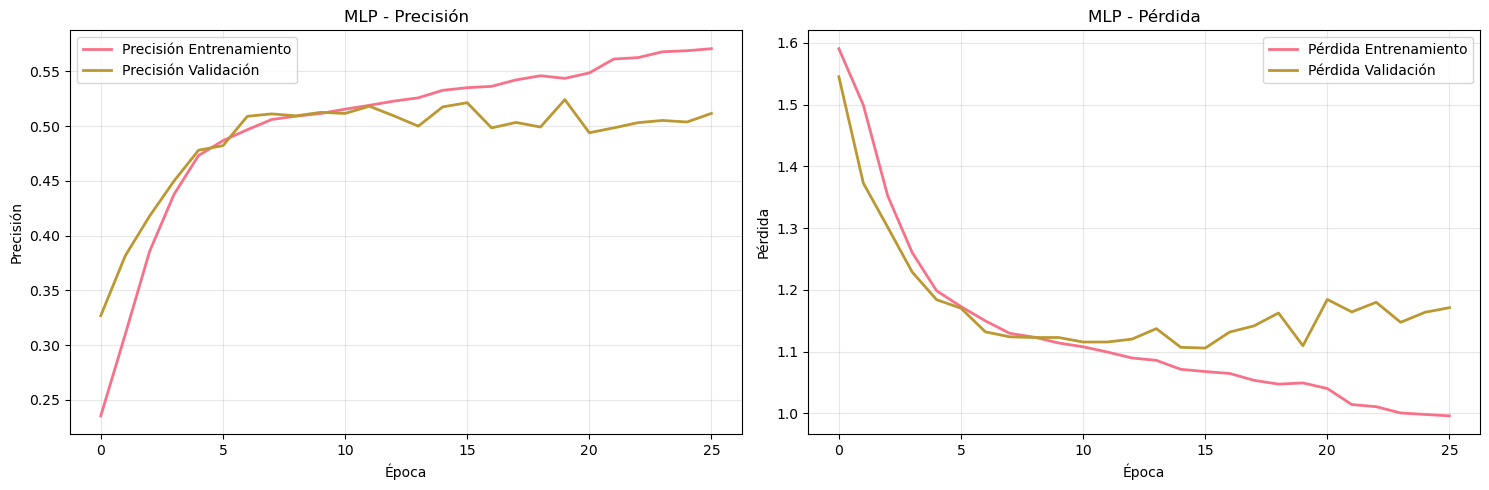

In [8]:
# Visualizar el historial de entrenamiento
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training_history.png")
)

## 7. Evaluación del Modelo

In [9]:
# Evaluar el modelo en el conjunto de prueba
evaluation_results = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    class_names=class_names
)

# Extraer métricas de evaluación
test_accuracy = evaluation_results['test_accuracy']
test_loss = evaluation_results['test_loss']
classification_rep = evaluation_results['classification_report']
y_true = evaluation_results['y_true']
y_pred = evaluation_results['y_pred']

print(f"\nResultados en conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...


2025-09-28 17:00:53.097513: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 17:00:53.097535: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-28 17:00:53.578002: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads

2025-09-28 17:00:53.712885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

 95/157 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step

2025-09-28 17:00:55.181700: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Precisión de Prueba: 0.5178
Pérdida de Prueba: 1.1049

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.65      0.64      0.64      1000
           2       0.40      0.44      0.42      1000
           3       0.38      0.34      0.36      1000
           4       0.50      0.36      0.42      1000
           5       0.63      0.80      0.70      1000

    accuracy                           0.52      5000
   macro avg       0.51      0.52      0.51      5000
weighted avg       0.51      0.52      0.51      5000


Resultados en conjunto de prueba:
Accuracy: 0.5178
Loss: 1.1049
F1-Score (macro): 0.5096
F1-Score (weighted): 0.5096


## 8. Matriz de Confusión

Matriz de confusión guardada en: output/MLP_confusion_matrix.png


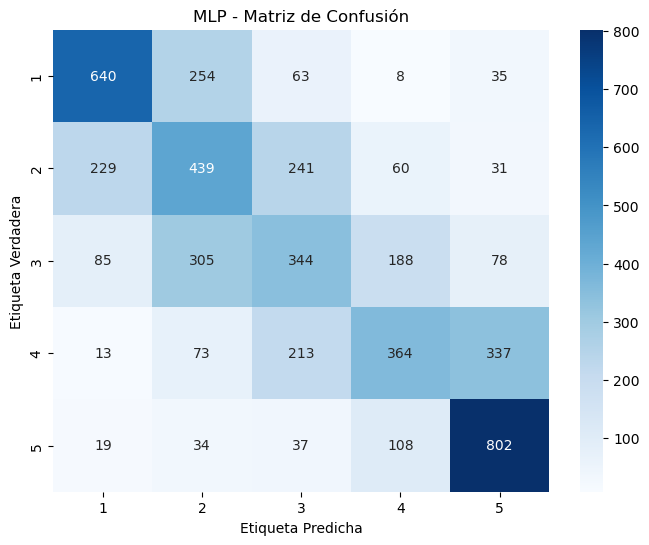

In [10]:
# Visualizar matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion_matrix.png")
)

## 9. Guardado de Resultados del Experimento

In [11]:
# Preparar datos del experimento para guardar
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'text_column': TEXT_COLUMN,
        'target_column': TARGET_COLUMN,
        'language_filter': FILTER_LANGUAGE,  # ← Nueva información de idioma
        'max_words': MAX_WORDS,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_layers': HIDDEN_LAYERS,
        'activation': ACTIVATION,
        'output_activation': OUTPUT_ACTIVATION,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'patience': PATIENCE,
        'optimizer': OPTIMIZER,
        'loss_function': LOSS_FUNCTION,
        'random_seed': RANDOM_SEED,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict(),
        'language_used': FILTER_LANGUAGE if FILTER_LANGUAGE else "multilingual"  # ← Nueva información
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'precision_macro': classification_rep['macro avg']['precision'],
        'recall_macro': classification_rep['macro avg']['recall'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar resultados del experimento
results_manager = ResultsManager(output_dir=OUTPUT_DIR)
experiment_id = results_manager.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado exitosamente.")
print(f"Idioma utilizado: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Modelo guardado en: {training_results['model_path']}")
print(f"Resultados guardados en: {OUTPUT_DIR}/experiment_history.json")

Experiment 5 results saved to output/experiment_history.json

Experimento #5 guardado exitosamente.
Idioma utilizado: en
Modelo guardado en: models/MLP_20250928_165747.h5
Resultados guardados en: output/experiment_history.json


## 10. Resumen del Experimento

In [12]:
# Mostrar resumen del experimento actual
print(f"RESUMEN DEL EXPERIMENTO #{experiment_id}")
print("=" * 60)
print(f"Modelo: {MODEL_TYPE}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma (todos)'}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Parámetros totales: {total_params:,}")
print(f"")
print(f"Dataset:")
print(f"  - Entrenamiento: {len(train_df):,} muestras")
print(f"  - Validaciónddcadasdsadsadsadsadsadsss""):,} muestras")
print(f"  - Prueba: {len(test_df):,} muestras")
print(f"")
print(f"Entrenamiento:")
print(f"  - Épocas: {training_results['epochs_trained']}/{EPOCHS}")
print(f"  - Tiempo: {training_results['training_time']:.1f}s")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"")
print(f"Resultados:")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"  - F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")
print(f"")
print(f"Hardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")

# Mostrar distribución de clases final
print(f"")
print(f"Distribución de clases utilizadas:")
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars}⭐: {count:,} ({percentage:.1f}%)")

RESUMEN DEL EXPERIMENTO #5
Modelo: MLP
Idioma: en
Arquitectura: [256, 128, 64]
Parámetros totales: 14,349,633

Dataset:
  - Entrenamiento: 200,000 muestras
  - Validaciónddcadasdsadsadsadsadsadsss):,} muestras
  - Prueba: 5,000 muestras

Entrenamiento:
  - Épocas: 26/50
  - Tiempo: 184.9s
  - Batch size: 512
  - Learning rate: 0.001

Resultados:
  - Test Accuracy: 0.5178
  - Test Loss: 1.1049
  - F1-Score (macro): 0.5096
  - F1-Score (weighted): 0.5096

Hardware: GPU

Distribución de clases utilizadas:
  1⭐: 40,000 (20.0%)
  2⭐: 40,000 (20.0%)
  3⭐: 40,000 (20.0%)
  4⭐: 40,000 (20.0%)
  5⭐: 40,000 (20.0%)


## 11. Historial de Experimentos

In [13]:
# Mostrar historial completo de experimentos
results_manager.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (5 experimentos)

ID  Modelo       Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MultiLayer_  en     0.5104     1.2213     15       74.3       200,000   
2   MultiLayer_  en     0.5208     1.1483     20       103.7      200,000   
3   MultiLayer_  en     0.5054     1.2300     18       96.1       200,000   
4   MLP          en     0.5082     1.1436     27       202.0      200,000   
5   MLP          en     0.5116     1.1711     26       184.9      200,000   

BEST EXPERIMENTS BY LANGUAGE:
--------------------------------------------------
en    : ID #2 - Accuracy: 0.5208 (200,000 samples)

OVERALL BEST: ID #2 (en) - Accuracy: 0.5208


## 12. Predicciones de Ejemplo

In [14]:
def predict_sample_texts(model, tokenizer, sample_texts, class_names, max_length):
    """
    Hacer predicciones en textos de ejemplo.
    
    Args:
        model: Modelo entrenado
        tokenizer: Tokenizer usado para entrenar
        sample_texts: Lista de textos de ejemplo
        class_names: Nombres de las clases
        max_length: Longitud máxima de secuencia
    """
    # Procesar textos
    sequences = tokenizer.texts_to_sequences(sample_texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding='post', truncating='post'
    )
    
    # Hacer predicciones
    predictions = model.predict(padded)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print("PREDICCIONES DE EJEMPLO:")
    print("=" * 60)
    
    for i, text in enumerate(sample_texts):
        pred_class = predicted_classes[i]
        confidence = predictions[i][pred_class]
        
        print(f"Texto: {text[:100]}...")
        print(f"Predicción: {class_names[pred_class]} estrellas (confianza: {confidence:.3f})")
        print("-" * 40)

# Ejemplos de textos para probar
sample_texts = [
    "Este producto es excelente, muy buena calidad y llegó rápido",
    "Terrible producto, no funciona como se describe", 
    "El producto está bien, cumple con lo básico",
    "Increíble calidad, superó mis expectativas completamente",
    "No recomiendo este producto, muy mala experiencia"
]

# Hacer predicciones en ejemplos
predict_sample_texts(
    model=model,
    tokenizer=data_loader.tokenizer,
    sample_texts=sample_texts,
    class_names=class_names,
    max_length=MAX_LENGTH
)

2025-09-28 17:00:57.615653: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
PREDICCIONES DE EJEMPLO:
Texto: Este producto es excelente, muy buena calidad y llegó rápido...
Predicción: 5 estrellas (confianza: 0.262)
----------------------------------------
Texto: Terrible producto, no funciona como se describe...
Predicción: 1 estrellas (confianza: 0.708)
----------------------------------------
Texto: El producto está bien, cumple con lo básico...
Predicción: 3 estrellas (confianza: 0.277)
----------------------------------------
Texto: Increíble calidad, superó mis expectativas completamente...
Predicción: 3 estrellas (confianza: 0.236)
----------------------------------------
Texto: No recomiendo este producto, muy mala experiencia...
Predicción: 2 estrellas (confianza: 0.225)
----------------------------------------


## 13. Análisis de Errores

In [15]:
# Analizar algunos errores del modelo
def analyze_errors(X_test, y_test, y_pred, test_df, text_column, target_column, n_examples=5):
    """
    Analizar ejemplos donde el modelo se equivocó.
    """
    # Encontrar índices donde el modelo se equivocó
    y_test_labels = np.argmax(y_test, axis=1)
    error_indices = np.where(y_test_labels != y_pred)[0]
    
    if len(error_indices) == 0:
        print("¡Perfecto! El modelo no cometió errores en el conjunto de prueba.")
        return
    
    print(f"ANÁLISIS DE ERRORES ({len(error_indices)} errores total)")
    print("=" * 60)
    
    # Mostrar algunos ejemplos de errores
    sample_errors = np.random.choice(error_indices, 
                                   min(n_examples, len(error_indices)), 
                                   replace=False)
    
    for i, idx in enumerate(sample_errors):
        true_label = y_test_labels[idx]
        pred_label = y_pred[idx]
        text = test_df.iloc[idx][text_column]
        
        print(f"Error #{i+1}:")
        print(f"Texto: {text[:150]}...")
        print(f"Etiqueta real: {true_label + 1} estrellas")
        print(f"Predicción: {pred_label + 1} estrellas")
        print("-" * 40)

# Realizar análisis de errores
analyze_errors(X_test, y_test, y_pred, test_df, TEXT_COLUMN, TARGET_COLUMN)

ANÁLISIS DE ERRORES (2411 errores total)
Error #1:
Texto: Similar to Neutrogena and less expensively...
Etiqueta real: 4 estrellas
Predicción: 2 estrellas
----------------------------------------
Error #2:
Texto: The stories are very well-written and very scary....
Etiqueta real: 4 estrellas
Predicción: 5 estrellas
----------------------------------------
Error #3:
Texto: Exactly as described. Is not a generic mount. Made for specific camera only....
Etiqueta real: 5 estrellas
Predicción: 4 estrellas
----------------------------------------
Error #4:
Texto: I love this water bottle. It's very soft to touch, not like the hard plastic from your typical water bottle. It has a little strainer cap under the li...
Etiqueta real: 5 estrellas
Predicción: 4 estrellas
----------------------------------------
Error #5:
Texto: This bulb is more of a turquoise color than blue. The neighbors made fun of it. :(...
Etiqueta real: 2 estrellas
Predicción: 4 estrellas
------------------------------------

## 14. Conclusiones y Próximos Pasos

### Resultados obtenidos:
- **Modelo implementado:** Perceptrón Multicapa (MLP) para clasificación de sentimientos
- **Arquitectura:** Embedding + GlobalAveragePooling + Capas densas + Dropout
- **Dataset:** Reviews de Amazon con clasificación de 1-5 estrellas
- **Métricas principales:** Accuracy, F1-Score, Precision, Recall

### Experimentos sugeridos:
1. **Ajuste de hiperparámetros:**
   - Probar diferentes dimensiones de embedding (50, 100, 200, 300)
   - Experimentar con diferentes arquitecturas de capas ocultas
   - Ajustar tasas de dropout y learning rate

2. **Mejoras del modelo:**
   - Implementar técnicas de regularización adicionales
   - Probar diferentes optimizadores (SGD, RMSprop, AdaGrad)
   - Experimentar con funciones de activación alternativas

3. **Preprocesamiento:**
   - Ajustar el tamaño del vocabulario
   - Experimentar con diferentes longitudes de secuencia
   - Implementar técnicas de limpieza de texto más sofisticadas

### Archivos generados:
- `models/`: Modelos entrenados guardados
- `output/experiment_history.json`: Historial completo de experimentos
- `output/`: Gráficos de entrenamiento y matrices de confusión

### Para la siguiente entrega:
- Reutilizar las funciones del archivo `helper.py`
- Comparar resultados con otras arquitecturas (RNN, CNN)
- Implementar técnicas de ensemble o voting
- Realizar análisis más profundo de los errores del modelo